# Problem 4: Visualizations and CAM

* <b>Learning Objective:</b> In problem 2, and 3, you are asked to use TensorFlow to design and train convolutiional neural networks. In this part of the assignment, you are going to play with some fun visualization tricks. We will provide the pretrained models of two well-known CNN architectures: AlexNet and VGG-16 Net to demonstrate visual patterns learned in the filters. In the last part, we introduce Grad-CAM, which is a recent work to visualize the attended heat map where the CNN looks at while predicting the labels of the images.
* <b>Provided Codes:</b> We provide the necessary code blocks for each section.
* <b>TODOs:</b> Follow the instructions to complete the TODO parts.

In [1]:
# A bit of setups
import tensorflow as tf

from tensorflow.python.framework import ops
from tensorflow.python.ops import gen_nn_ops
from lib.datasets import *

from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg

%matplotlib inline
%reload_ext autoreload
%autoreload 2

### Download the Model
Download the vgg16 pretrained model from the [ftp://mi.eng.cam.ac.uk/pub/mttt2/models/vgg16.npy](ftp://mi.eng.cam.ac.uk/pub/mttt2/models/vgg16.npy)  
Download the AlexNet pretrained model from the link [BVLC_ALEXNET](http://www.cs.toronto.edu/~guerzhoy/tf_alexnet/bvlc_alexnet.npy)  
And save the two models (.npy files) to lib/tf_models/

In [2]:
import numpy as np
from lib.tf_models import vgg16
import os
import math

### Visualizing learned filters
In this section we will show you how to visualize the learned convolutional filters.

In [3]:
# Define the vgg network for visualizations
vgg_viz = vgg16.Vgg16()
vgg_viz.load()
vgg_viz.setup()

Model from /home/jupyter/CSCI599-Assignment1/lib/tf_models/vgg16.npy
Pretrained VGG16 successfully loaded!


In [4]:
# Useful function to arrange the images to be shown as a squared grid
def viz_grid(Xs, ubound=255.0, padding=1):
    N, H, W, C = Xs.shape
    grid_size = int(math.ceil(math.sqrt(N)))
    grid_height = H * grid_size + padding * (grid_size - 1)
    grid_width = W * grid_size + padding * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C))
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = Xs[next_idx]
                grid[y0:y1, x0:x1] = img
                next_idx += 1
            x0 += W + padding
            x1 += W + padding
        y0 += H + padding
        y1 += H + padding
    return grid

Model from lib/tf_models/bvlc_alexnet.npy
Pretrained AlexNet successfully loaded!
Model from lib/tf_models/vgg16.npy
Pretrained Vgg-16 successfully loaded!


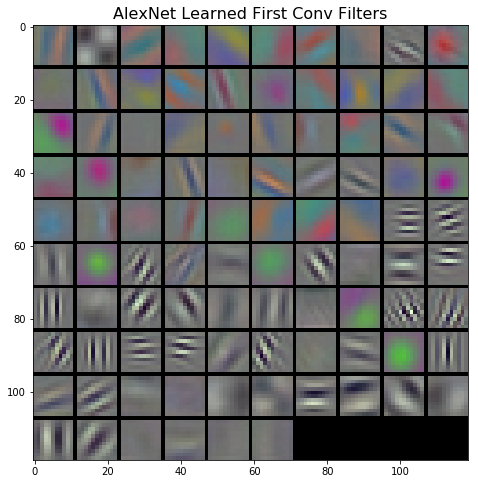

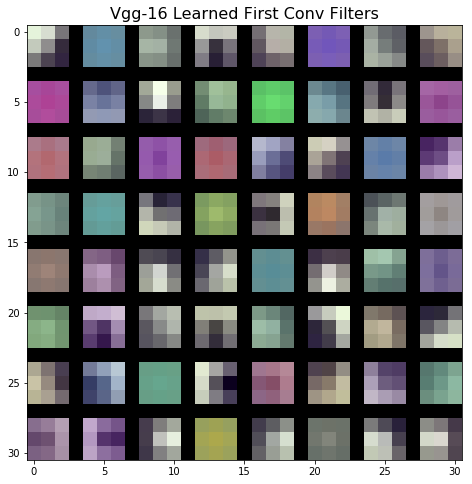

In [5]:
model_paths = {
    "Vgg-16": os.path.join("lib/tf_models", "vgg16.npy"),
    "AlexNet": os.path.join("lib/tf_models", "bvlc_alexnet.npy")
}

for net in sorted(model_paths):
    model_path = model_paths[net]
    print("Model from {}".format(model_path))
    pretrained = np.load(model_path, encoding='latin1').item()
    print("Pretrained {} successfully loaded!".format(net))

    first_conv = "conv1_1" if net == "Vgg-16" else "conv1"
    
    conv1 = pretrained[first_conv]
    #############################################################################
    # TODO: Extract the weight and bias from conv1                              #
    # HINT: What's the data type of conv1?                                      #
    #############################################################################
    # print (type(conv1))
    # print ('weight shape is {} and bias shape is {}'.format(conv1[0].shape, conv1[1].shape))
    # Now is (H, W, C, n)
    w_conv1, b_conv1 = conv1[0], conv1[1]
    
    #############################################################################
    # TODO: Scale the kernel weights to [0,1]                                   #
    #############################################################################
    w_01 = None
    w_conv1_max = np.max(w_conv1)
    w_conv1_min = np.min(w_conv1)
    w_01 = (w_conv1 - w_conv1_min) / (w_conv1_max - w_conv1_min)
    #############################################################################
    # TODO: Transpose the scaled kernel weights so that the                     #
    # number of filters comes first in the dimension as (n, H, W, C)            #
    #############################################################################
    wT = None
    wT = np.transpose(w_01, (3, 0, 1, 2))
    # print('shape of w_01 and wT are {} and {}'.format(w_01.shape, wT.shape))
    
    # Define a figure
    fig = plt.figure(figsize=(8,8))   
    ax1 = plt.subplot(111)

    rgb_w = []  # list of filters
    n, H, W, C = wT.shape
    
    # assert n == 96 and H == 11 and W == 11 and C == 3
    # print(n, H, W, C)
    #############################################################################
    # TODO: Store each of the n transposed kernel weights                       #
    # to the rgb_w list so the list is of dimension (n, (H, W, C))              #
    #############################################################################
    rgb_w = [wT[i] for i in range(n)]
    
    
    # Transform the python list to numpy array
    rgb_w = np.asarray(rgb_w)
    
    # Grid the rgb_w
    grid = viz_grid(rgb_w)

    ax1.imshow(grid[...,::-1])
    ax1.set_title('{} Learned First Conv Filters'.format(net), fontsize=16)

### Load CIFAR-10 Data

In [6]:
data_train, labels_train, data_test, labels_test = CIFAR10('data/cifar-10-batches-py')

### <font color="Scarlet">Run the following lines of code, and whenever you encounter problems with tf graph, rerun them again<font>

In [7]:
tf.reset_default_graph()
sess = tf.Session()

### Layers in Problem 2
Copy and paste your implementation for layers in problem 2 to below

In [8]:
# Define conv layer and fully-connected layer
## Impelment -----
# Define max pooling and conv layers

def conv2d(input, kernel_size, stride, num_filter):
    stride_shape = [1, stride, stride, 1]
    filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]

    W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
    b = tf.get_variable('b', [1, 1, 1, num_filter], initializer=tf.constant_initializer(0.0))
    return tf.nn.conv2d(input, W, stride_shape, padding='SAME') + b

def max_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.max_pool(input, ksize=ksize, strides=strides, padding='SAME')

#############################################################################
# TODO: Complete the following functions                                    #
#############################################################################
def flatten(input):
    """
        - input: input tensors
    """
    output = tf.contrib.layers.flatten(input)
    return output

def fc(input, num_output):
    """
        - input: input tensors
        - num_output: int, the output dimension
    """
    # tf.contrib.layers.fully_connected has default setting where relu is activation
    # Instead use tf.layers.dense
    # output = tf.contrib.layers.fully_connected(intput, num_output)
    output = tf.layers.dense(input, units=num_output)
    return output

def norm(input, is_training):
    """
        - input: input tensors
        - is_training: boolean, if during training or not
    """
    # The same reason above
    # output = tf.contrib.layers.batch_norm(input, decay=0.9, center=True, activation_fn=tf.nn.relu,
    #                                     epsilon=1e-5, is_training=is_training)
    output = tf.layers.batch_normalization(input, training=is_training)
    return output
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################
## -----

### Sample convolutional neural network in Problem 2 (Your own)
Copy and paste your implementation for the BaseModel in problem 2 to below

In [9]:
class BaseModel(object):
    def __init__(self):
        self.num_epoch = 5
        self.batch_size = 128
        self.log_step = 50
        self._build_model()

    def _model(self):
        ###########################
        ###### Your Network #######
        ###########################
        print('-' * 5 + '  Sample model  ' + '-' * 5)

        print('intput layer: ' + str(self.X.get_shape()))

        with tf.variable_scope('conv1'):
            self.conv1 = conv2d(self.X, 7, 1, 32)
            self.relu1 = tf.nn.relu(self.conv1)
            self.pool1 = max_pool(self.relu1, 3, 2)            
            print('conv1 layer: ' + str(self.pool1.get_shape()))

        with tf.variable_scope('conv2'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.conv2 = conv2d(self.pool1, 5, 1, 64)
            self.relu2 = tf.nn.relu(self.conv2)
            self.pool2 = max_pool(self.relu2, 3, 2)
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('conv2 layer: ' + str(self.pool2.get_shape()))

        #############################################################################
        # TODO: Flatten the output tensor from conv2 layer                          #
        #############################################################################
        self.flat = flatten(self.pool2)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################      
        print('flat layer: ' + str(self.flat.get_shape()))

        with tf.variable_scope('fc3'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.fc3 = fc(self.flat, 384)
            self.relu3 = tf.nn.relu(self.fc3)
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc3 layer: ' + str(self.relu3.get_shape()))
            
        with tf.variable_scope('fc4'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.fc4 = fc(self.relu3, 10)
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc4 layer: ' + str(self.fc4.get_shape()))
            
        # Return the last layer
        return self.fc4
        ###########################
        ### End of Your Network ###
        ###########################

    def _input_ops(self):
        # placeholders
        self.X = tf.placeholder(tf.float32, [None, 32, 32, 3])
        self.Y = tf.placeholder(tf.int64, [None])

        # extra placeholders
        self.is_train = tf.placeholder(tf.bool)
        self.keep_prob = tf.placeholder(tf.float32)

    def _build_optimizer(self):
        # adam optimizer
        global_step = tf.Variable(0, trainable=False)
        starter_learning_rate = 5e-4
        learning_rate = tf.train.exponential_decay(
            starter_learning_rate, global_step,
            500, 0.96, staircase=True)
        optimizer = tf.train.AdamOptimizer(learning_rate)
        self.train_op = optimizer.minimize(self.loss_op, global_step=global_step)
        
    def _loss(self, labels, logits):
        loss = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits)
        self.loss_op = tf.reduce_mean(loss)

    def _build_model(self):
        # define input variables
        self._input_ops()

        # convert Y to one-hot vector
        labels = tf.one_hot(self.Y, 10)

        # build a model and get logits
        logits = self._model()

        # compute loss
        self._loss(labels, logits)
        
        # build optimizer
        self._build_optimizer()

        # compute accuracy
        predict = tf.argmax(logits, 1)
        correct = tf.equal(predict, self.Y)
        self.accuracy_op = tf.reduce_mean(tf.cast(correct, tf.float32))

    def train(self, sess, X_train, Y_train, X_val, Y_val):
        sess.run(tf.global_variables_initializer())

        step = 0
        losses = []
        accuracies = []
        for epoch in range(self.num_epoch):
            print('train for epoch %d' % epoch)
            for i in range(num_training // self.batch_size):
                X_ = X_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]

                feed_dict = {self.X: X_,
                             self.Y: Y_,
                             self.is_train: True,
                             self.keep_prob: 0.4}
                fetches = [self.train_op, self.loss_op, self.accuracy_op]

                _, loss, accuracy = sess.run(fetches, feed_dict=feed_dict)
                losses.append(loss)
                accuracies.append(accuracy)

                if step % self.log_step == 0:
                    print('iteration (%d): loss = %.3f, accuracy = %.3f' %
                        (step, loss, accuracy))
                step += 1

            # plot training curves
            ## Impelment -----
            # Graph 1. X: epoch, Y: training loss
            ## -----
            
            # validation
            print('validation for epoch %d' % epoch)
            val_accuracy = self.evaluate(sess, X_val, Y_val)
            print('epoch (%d): validation accuracy = %.3f' % (epoch, val_accuracy))

    def evaluate(self, sess, X_eval, Y_eval):
        eval_accuracy = 0.0
        eval_iter = 0
        for i in range(X_eval.shape[0] // self.batch_size):
            X_ = X_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]

            feed_dict = {self.X: X_,
                         self.Y: Y_,
                         self.is_train: False,
                         self.keep_prob: 1.0}
            accuracy = sess.run(self.accuracy_op, feed_dict=feed_dict)
            eval_accuracy += accuracy
            eval_iter += 1
        return eval_accuracy / eval_iter

### Visualize the learned filters on your trained CIFAR-10 network!
Repeat the above procedure on your own trained network, for the first convolutional layer

In [10]:
model = BaseModel()

-----  Sample model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
flat layer: (?, 4096)
fc3 layer: (?, 384)
fc4 layer: (?, 10)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [11]:
# Restore the model using parameters dict
variables = tf.global_variables()
param_dict = {}
for var in variables:
    var_name = var.name[:-2]
    print('Loading {} from checkpoint. Name: {}'.format(var.name, var_name))
    param_dict[var_name] = var
saver = tf.train.Saver()
saver.restore(sess, "lib/tf_models/problem2/csci-599_sample.ckpt")

Loading conv1/w:0 from checkpoint. Name: conv1/w
Loading conv1/b:0 from checkpoint. Name: conv1/b
Loading conv2/w:0 from checkpoint. Name: conv2/w
Loading conv2/b:0 from checkpoint. Name: conv2/b
Loading fc3/dense/kernel:0 from checkpoint. Name: fc3/dense/kernel
Loading fc3/dense/bias:0 from checkpoint. Name: fc3/dense/bias
Loading fc4/dense/kernel:0 from checkpoint. Name: fc4/dense/kernel
Loading fc4/dense/bias:0 from checkpoint. Name: fc4/dense/bias
Loading Variable:0 from checkpoint. Name: Variable
Loading beta1_power:0 from checkpoint. Name: beta1_power
Loading beta2_power:0 from checkpoint. Name: beta2_power
Loading conv1/w/Adam:0 from checkpoint. Name: conv1/w/Adam
Loading conv1/w/Adam_1:0 from checkpoint. Name: conv1/w/Adam_1
Loading conv1/b/Adam:0 from checkpoint. Name: conv1/b/Adam
Loading conv1/b/Adam_1:0 from checkpoint. Name: conv1/b/Adam_1
Loading conv2/w/Adam:0 from checkpoint. Name: conv2/w/Adam
Loading conv2/w/Adam_1:0 from checkpoint. Name: conv2/w/Adam_1
Loading conv2

(7, 7, 3, 32) (1, 1, 1, 32)


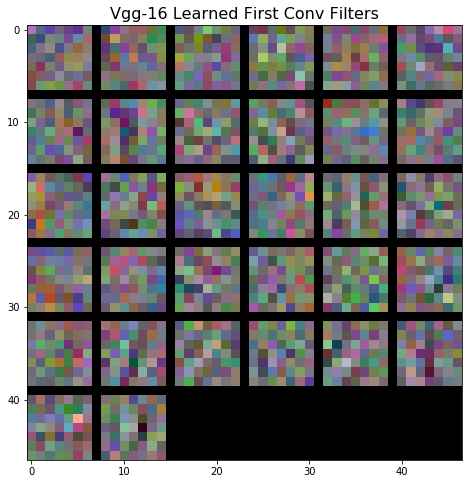

In [13]:
# TODO:
with sess.as_default():
    with tf.variable_scope("conv1", reuse=True):
        conv1 = tf.get_variable("w")
        b1    = tf.get_variable("b")
    print (conv1.shape, b1.shape)
    
    #############################################################################
    # TODO: Extract the weight and bias from conv1                              #
    # For tf models, you should use .eval() function on variables and           #
    # sess.run() function to extract the features to ndarray                    #
    #############################################################################
    w_conv1, b_conv1 = conv1.eval(), b1.eval()

    #############################################################################
    # TODO: Scale the kernel weights to [0,1]                                   #
    #############################################################################
    w_01 = None
    w_conv1_max = np.max(w_conv1)
    w_conv1_min = np.min(w_conv1)
    
    w_01 = (w_conv1 - w_conv1_min) / (w_conv1_max - w_conv1_min)
    
    #############################################################################
    # TODO: Transpose the scaled kernel weights so that the                     # 
    # number of filters comes first in the dimension (n, H, W, C)               #
    #############################################################################
    wT = None
    wT = np.transpose(w_01, (3, 0, 1, 2))

    # Define a figure
    fig = plt.figure(figsize=(8,8))   
    ax1 = plt.subplot(111)

    rgb_w = []  # list of filters
    n, H, W, C = wT.shape
    
    #############################################################################
    # TODO: Store each of the n transposed kernel weights                       #
    # to the rgb_w list so the list is of dimension (n, (H, W, C))              #
    #############################################################################
    rgb_w = [wT[i] for i in range(n)]
    
    # Transform the python list to numpy array
    rgb_w = np.asarray(rgb_w)
    grid = viz_grid(rgb_w)

    ax1.imshow(grid[...,::-1])
    ax1.set_title('{} Learned First Conv Filters'.format(net), fontsize=16)

## Visualizing Activations
Now we saw the learned filters, and observed that they have some patterns. We will go one step forward to visualize the activation maps produced by different convolutional filters. You will see that as we go deeper through the layers of a network the activation maps gradually represent higher and higher levels of abstraction in the images.  
Now, let's get some warm-ups by running the following visualization code blocks for a simple model trained on MNIST dataset.

In [14]:
import tensorflow.contrib.slim as slim
from tensorflow.examples.tutorials.mnist import input_data

In [16]:
mnist = input_data.read_data_sets("data/MNIST_data/", one_hot=True, source_url='http://yann.lecun.com/exdb/mnist/')

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [17]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, [None, 784],name="x-in")
y = tf.placeholder(tf.float32, [None, 10],name="y-in")
keep_prob = tf.placeholder("float")

x_reshaped = tf.reshape(x,[-1,28,28,1])
x_tiled = tf.tile(x_reshaped, [1,1,1,3])
sconv_1 = slim.conv2d(x_tiled,5,[5,5])
spool_1 = slim.max_pool2d(sconv_1,[2,2])
sconv_2 = slim.conv2d(spool_1,5,[5,5])
spool_2 = slim.max_pool2d(sconv_2,[2,2])
sconv_3 = slim.conv2d(spool_2,20,[5,5])
s_dropout3 = slim.dropout(sconv_3, keep_prob)
output = slim.fully_connected(slim.flatten(s_dropout3), 10, activation_fn=tf.nn.softmax)

cross_entropy = -tf.reduce_sum(y * tf.log(output))
correct_prediction = tf.equal(tf.argmax(output,1 ), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

In [18]:
batchSize = 50
dropout_p = 0.5

sess = tf.Session(config=tf.ConfigProto(device_count={'GPU': 0}))
init = tf.global_variables_initializer()
sess.run(init)

# Train the network
for i in range(2001):
    batch = mnist.train.next_batch(batchSize)
    sess.run(train_step, feed_dict={x:batch[0], y:batch[1], keep_prob:dropout_p})
    if i % 100 == 0 and i != 0:
        trainAccuracy = sess.run(accuracy, feed_dict={x:batch[0], y:batch[1], keep_prob:1.0})
        print("step %d, training accuracy %g"%(i, trainAccuracy))

step 100, training accuracy 0.38
step 200, training accuracy 0.5
step 300, training accuracy 0.72
step 400, training accuracy 0.78
step 500, training accuracy 0.86
step 600, training accuracy 0.86
step 700, training accuracy 0.86
step 800, training accuracy 0.94
step 900, training accuracy 0.96
step 1000, training accuracy 0.8
step 1100, training accuracy 0.96
step 1200, training accuracy 0.84
step 1300, training accuracy 0.94
step 1400, training accuracy 0.94
step 1500, training accuracy 0.92
step 1600, training accuracy 0.92
step 1700, training accuracy 0.94
step 1800, training accuracy 0.92
step 1900, training accuracy 0.94
step 2000, training accuracy 0.92


In [19]:
testAccuracy = sess.run(accuracy, feed_dict={x:mnist.test.images,y:mnist.test.labels, keep_prob:1.0})
print("test accuracy {}".format(testAccuracy))

test accuracy 0.9405999779701233


In [22]:
# function for visualizing the activations
def getActivations_mnist(layer, features):
    outs = sess.run(layer, feed_dict={x:np.reshape(features,[1,784],order='F'), keep_prob:1.0})
    outs = np.transpose(outs, [3, 1, 2, 0])
    fig = plt.figure(figsize=(4,4))   
    ax1 = plt.subplot(111)
    grid = viz_grid(outs)
    ax1.imshow(grid[...,0])
    ax1.set_title('{} Activations'.format(layer.name), fontsize=16)

The Image for activation visualizations:


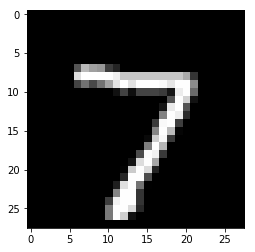

In [23]:
imageToUse = mnist.test.images[0]
imageToShow = np.expand_dims(np.reshape(imageToUse,[28,28]), axis=-1)
imageToShow = np.tile(imageToShow, (1,1,3))
plt.imshow(imageToShow, interpolation="nearest", cmap="gray")
print ("The Image for activation visualizations:")

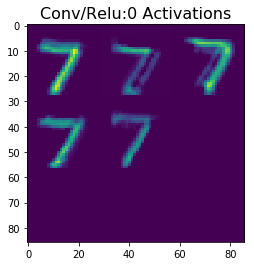

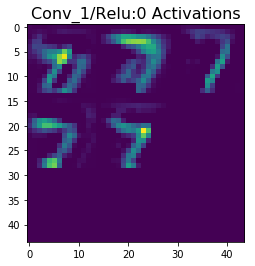

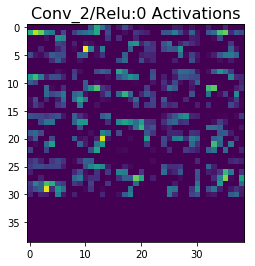

In [24]:
# Visualize the first 3 activation maps after convs
getActivations_mnist(sconv_1, imageToUse)
getActivations_mnist(sconv_2, imageToUse)
getActivations_mnist(sconv_3, imageToUse)

## Visualize the activations on your own model
Now repeat the above procedure on your own model.

In [25]:
def getActivations_cifar10(layer, stimuli):
    #############################################################################
    # TODO: Fill out the following block for running the session                #
    #############################################################################
    units = None
    units = sess.run(layer, feed_dict={model.X:stimuli, model.is_train:False, model.keep_prob:1.0})
    units = np.transpose(units, [3, 1, 2, 0])
    
    # Define the figure
    fig = plt.figure(figsize=(8,8))   
    ax1 = plt.subplot(111)
    grid = viz_grid(units)
    ax1.imshow(grid[...,0])
    ax1.set_title('{} Activations'.format(layer.name), fontsize=16)

There are total 10000 images in test set
Image 999 in test set


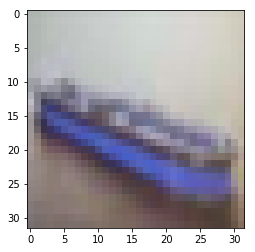

In [26]:
print ("There are total {} images in test set".format(len(data_test)))
#############################################################################
# TODO: Try out some indices you want to see!                               #
#############################################################################
query_idx = 999

# Process the indicated issue
query_idx = min(max(query_idx, 0), 999)
cifar10ToUse = data_test[query_idx].astype(np.uint8)
cifar10ToUse= cifar10ToUse[...,::-1]
plt.imshow(cifar10ToUse)
print ("Image {} in test set".format(query_idx))

In [27]:
tf.reset_default_graph()
sess = tf.Session(config=tf.ConfigProto(device_count={'GPU': 0}))

# Restore the model using parameters dict
model = BaseModel()
variables = tf.global_variables()
param_dict = {}
for var in variables:
    var_name = var.name[:-2]
    print('Loading {} from checkpoint. Name: {}'.format(var.name, var_name))
    param_dict[var_name] = var
saver = tf.train.Saver()
saver.restore(sess, "lib/tf_models/problem2/csci-599_sample.ckpt")

-----  Sample model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
flat layer: (?, 4096)
fc3 layer: (?, 384)
fc4 layer: (?, 10)
Loading conv1/w:0 from checkpoint. Name: conv1/w
Loading conv1/b:0 from checkpoint. Name: conv1/b
Loading conv2/w:0 from checkpoint. Name: conv2/w
Loading conv2/b:0 from checkpoint. Name: conv2/b
Loading fc3/dense/kernel:0 from checkpoint. Name: fc3/dense/kernel
Loading fc3/dense/bias:0 from checkpoint. Name: fc3/dense/bias
Loading fc4/dense/kernel:0 from checkpoint. Name: fc4/dense/kernel
Loading fc4/dense/bias:0 from checkpoint. Name: fc4/dense/bias
Loading Variable:0 from checkpoint. Name: Variable
Loading beta1_power:0 from checkpoint. Name: beta1_power
Loading beta2_power:0 from checkpoint. Name: beta2_power
Loading conv1/w/Adam:0 from checkpoint. Name: conv1/w/Adam
Loading conv1/w/Adam_1:0 from checkpoint. Name: conv1/w/Adam_1
Loading conv1/b/Adam:0 from checkpoint. Name: conv1/b/Adam
Loading conv1/b/Adam_1:0 

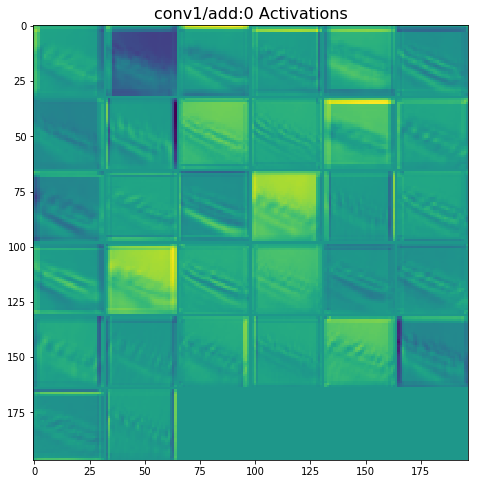

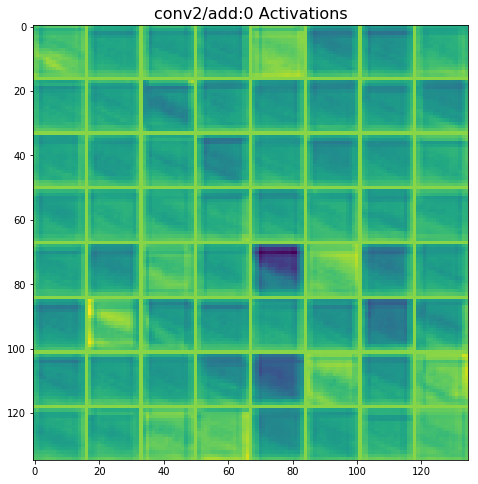

In [28]:
cifar10ToUse_with_batch = np.expand_dims(cifar10ToUse, axis=0)
####################################################################
# TODO: Visualize the activations of each conv layer in your model #
####################################################################
getActivations_cifar10(model.conv1, cifar10ToUse_with_batch)
getActivations_cifar10(model.conv2, cifar10ToUse_with_batch)

### Inline Question: Describe your observation of how the activation changes throughout the network below:
#### Ans: Convolution and activation layers work as filters and will extract various features from expected aspects. Just from obversation, these layers will partially focus on parts of the input and 'search for' hidden features.

## Gradient-weighted Class Activation Mapping (Grad-CAM)
Grad-CAM is a technique for "visually interpreting" the predictions of a Convolutional Neural
Network (CNN)-based model. This technique essentially uses the gradients of any target concept
(a predicted class such as "cat"), flowing into the final convolutional layer to produce a coarse localization
map attending regions in the image that are important for prediction of the concept.
Please read the original paper [Grad-CAM](https://arxiv.org/pdf/1610.02391.pdf) for more details.

### Register the guided backpropagation ReLU (Run this function only once)

In [29]:
# Replace vanila relu to guided relu to get guided backpropagation.
@ops.RegisterGradient("GuidedRelu")
def _GuidedReluGrad(op, grad):
    return tf.where(0. < grad, gen_nn_ops.relu_grad(grad, op.outputs[0]), tf.zeros(grad.get_shape()))

### Some useful functions

In [30]:
import cv2

def imgread(path):
    print ("Image:", path.split("/")[-1])
    # Read in the image using python opencv
    img = cv2.imread(path)
    img = img / 255.0
    print ("Raw Image Shape: ", img.shape)
    
    # Center crop the image
    short_edge = min(img.shape[:2])
    W, H, C = img.shape
    to_crop = min(W, H)
    cent_w = int((img.shape[1] - short_edge) / 2)
    cent_h = int((img.shape[0] - short_edge) / 2)
    img_cropped = img[cent_h:cent_h+to_crop, cent_w:cent_w+to_crop]
    print ("Cropped Image Shape: ", img_cropped.shape)
    
    # Resize the cropped image to 224 by 224 for VGG16 network
    img_resized = cv2.resize(img_cropped, (224, 224), interpolation=cv2.INTER_LINEAR)
    print ("Resized Image Shape: ", img_resized.shape)
    return img_resized

def predicted_labels(score, synset_path):
    fi = open(synset_path, "rb")
    synset = []
    for line in fi:
        synset.append(line.rstrip().lstrip())
    
    # The predictions, reverse ordered
    pred = np.argsort(score)[::-1]

    # Top 1 and Top 5
    top1 = synset[pred[0]]
    print ("\nTop1, Label: {}, score: {}".format(top1, score[pred[0]]))
    top5 = [(synset[pred[i]], score[pred[i]]) for i in range(5)]
    for i in range(1,5):
        print ("Top{}, Label: {} score: {}".format(i+1, top5[i][0], top5[i][1]))
    return top1, top5

### Visualization Function

In [31]:
def visualize(image, output, grads, gb_grads):
    # Reverse the BGR channel to RGB
    gb_grads = gb_grads[...,::-1]

    # Initialzie CAM weights
    CAM = np.ones(output.shape[0 : 2], dtype = np.float32)  

    # Taking a weighted average
    cam_w = np.mean(grads, axis = (0, 1))
    for i, w in enumerate(cam_w):
        CAM += w * output[:, :, i]

    # Passing through ReLU
    CAM = np.maximum(CAM, 0)
    # scale CAM to [0,1]
    CAM /= np.max(CAM)
    # Resize the CAM to 224 by 224
    CAM = cv2.resize(CAM, (224, 224), interpolation=cv2.INTER_LINEAR)
    
    # scale guided backprop gradients to [0,1]
    gb_grads -= np.min(gb_grads)
    gb_grads /= np.max(gb_grads)
    
    # scale the original to [0,1]
    img_toshow = image.astype(float)    
    img_toshow -= np.min(img_toshow)
    img_toshow /= img_toshow.max()

    # Render the CAM heatmap
    heatmap = cv2.applyColorMap(np.uint8(CAM*255.0), cv2.COLORMAP_JET)

    # Grad-CAM
    CAM_gb = CAM.copy()
    CAM_gb = np.expand_dims(np.squeeze(CAM_gb), axis=-1)
    gd_gb = gb_grads * np.tile(CAM_gb, (1,1,3))
    
    # Draw the results figures
    fig = plt.figure(figsize=(10,10))   
    ax1 = plt.subplot(221)
    ax2 = plt.subplot(222)
    ax3 = plt.subplot(223)
    ax4 = plt.subplot(224)
    
    ax1.imshow(img_toshow[...,::-1])
    ax1.set_title('Input Image')
    ax2.imshow(heatmap)
    ax2.set_title('Grad-CAM')
    ax3.imshow(gb_grads)
    ax3.set_title('guided backpropagation')
    ax4.imshow(gd_gb)
    ax4.set_title('guided Grad-CAM')

    # Show the resulting image
    plt.show()

### Grad-CAM Main Implementation

Image: corgi.jpg
Raw Image Shape:  (600, 900, 3)
Cropped Image Shape:  (600, 600, 3)
Resized Image Shape:  (224, 224, 3)
Image: cat_and_dog.jpg
Raw Image Shape:  (480, 640, 3)
Cropped Image Shape:  (480, 480, 3)
Resized Image Shape:  (224, 224, 3)
Image: cat_and_dog.jpg
Raw Image Shape:  (480, 640, 3)
Cropped Image Shape:  (480, 480, 3)
Resized Image Shape:  (224, 224, 3)
Model from /home/jupyter/CSCI599-Assignment1/lib/tf_models/vgg16.npy
Pretrained VGG16 successfully loaded!

Top1, Label: b'n02113186 Cardigan, Cardigan Welsh corgi', score: 0.3729478120803833
Top2, Label: b'n02113023 Pembroke, Pembroke Welsh corgi' score: 0.2394900918006897
Top3, Label: b'n02109961 Eskimo dog, husky' score: 0.21841849386692047
Top4, Label: b'n02110185 Siberian husky' score: 0.10455705225467682
Top5, Label: b'n02110063 malamute, malemute, Alaskan malamute' score: 0.038400981575250626


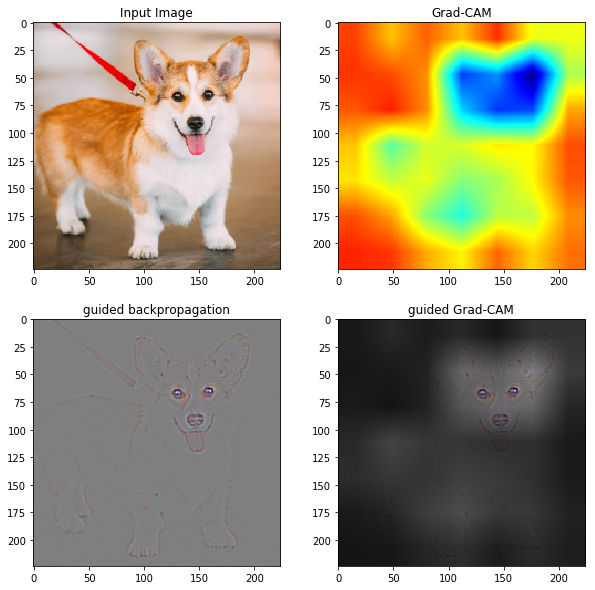


Top1, Label: b'n02110958 pug, pug-dog', score: 0.39031845331192017
Top2, Label: b'n02093428 American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier' score: 0.11102316528558731
Top3, Label: b'n02123159 tiger cat' score: 0.08522205054759979
Top4, Label: b'n02108422 bull mastiff' score: 0.052628207951784134
Top5, Label: b'n02123045 tabby, tabby cat' score: 0.04932358115911484


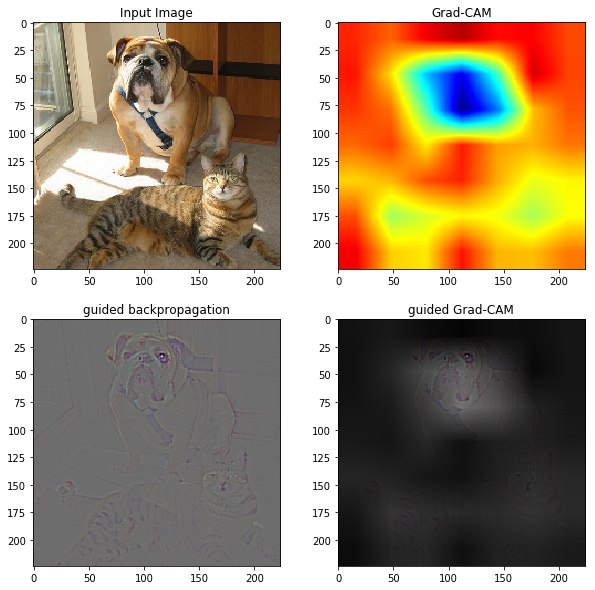


Top1, Label: b'n02110958 pug, pug-dog', score: 0.39031845331192017
Top2, Label: b'n02093428 American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier' score: 0.11102316528558731
Top3, Label: b'n02123159 tiger cat' score: 0.08522205054759979
Top4, Label: b'n02108422 bull mastiff' score: 0.052628207951784134
Top5, Label: b'n02123045 tabby, tabby cat' score: 0.04932358115911484


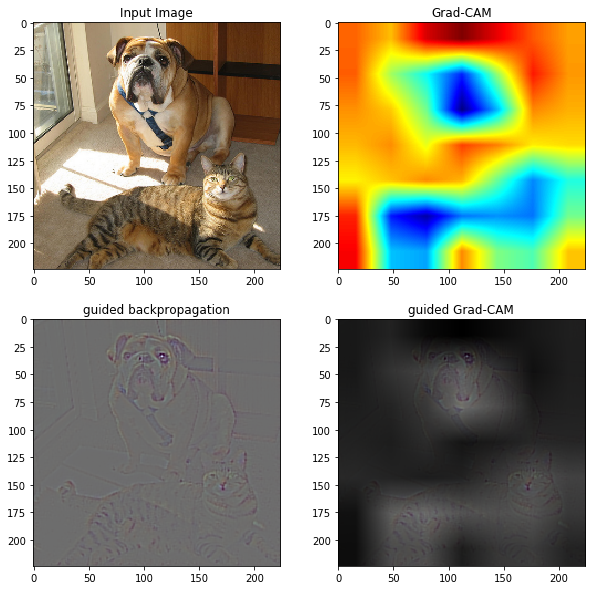

In [33]:
num_classes = 1000

# Read in the image
img1 = imgread("images/corgi.jpg")
img2 = imgread("images/cat_and_dog.jpg")
img3 = imgread("images/cat_and_dog.jpg")

# Expand one dimension to take on the batch dimension
img1 = np.expand_dims(img1, axis=0)
img2 = np.expand_dims(img2, axis=0)
img3 = np.expand_dims(img3, axis=0)

# Define a all zero gradients of the shape 1000
zero_grads = np.array([0 for i in range(num_classes)])

# The indices of the classes are provided for you
class_num1 = 263  # Pembroke, Pembroke Welsh corgi
class_num2 = 254  # Pug, pug-dog
class_num3 = 282  # Tiger cat

# Define a one-hot gradient vector where the only activated gradient
# is of the corresponding indices from above 
one_hot_grad1 = zero_grads.copy()
one_hot_grad2 = zero_grads.copy()
one_hot_grad3 = zero_grads.copy()
one_hot_grad1[class_num1] = 1.0
one_hot_grad2[class_num2] = 1.0
one_hot_grad3[class_num3] = 1.0
one_hot_grad1 = np.expand_dims(one_hot_grad1, axis=0)
one_hot_grad2 = np.expand_dims(one_hot_grad2, axis=0)
one_hot_grad3 = np.expand_dims(one_hot_grad3, axis=0)

#############################################################################
# TODO: Construct a minibatch of data and labels of the                     #
# images using concatenate                                                  #
#############################################################################
minibatch = np.concatenate((img1, img2, img3), axis=0)
mini_label = np.concatenate((one_hot_grad1, one_hot_grad2, one_hot_grad3), axis=0)

# Define the batch size
batch_size = 3

# Create tensorflow graph for evaluation
graph = tf.Graph()
with graph.as_default():
    with graph.gradient_override_map({'Relu': 'GuidedRelu'}):
        # Define the VGG16 network and setup
        # Please take a look at the lib/tf_models/vgg16.py for more details
        # of the VGG16 network
        vgg = vgg16.Vgg16()
        vgg.load()
        vgg.setup()
        
        #############################################################################
        # TODO: Define the signal and the loss                                      #
        # HINT: To construnct the signal, simply extract the final fully connected  #
        # layer and perform a element-wise multiplication  on the one-hot vectors   #
        # The loss is then defined as the average of the signal                     #
        #############################################################################
        signal = tf.multiply(vgg.fc8, mini_label)
        loss = tf.reduce_sum(signal)

        #############################################################################
        # TODO: Compute the gradient of pool5 layer for generating Grad-CAM         #
        #############################################################################
        # grad_pool5 = tf.gradients(loss, vgg.pool5)
        # print(type(grad_pool5))
        # print(len(grad_pool5))
        grad_pool5 = tf.gradients(loss, vgg.pool5)[0]

        #############################################################################
        # TODO: Perform a guided backpropagtion back to the input layer             #
        #############################################################################
        grad_input = tf.gradients(loss, vgg.inputs)[0]

        eps = tf.constant(1e-5)
        #############################################################################
        # TODO: Normalize the gradients, and add a small number epsilon to it       #
        #############################################################################
        normalized = tf.math.l2_normalize(grad_pool5, epsilon=eps)
        # normalized = tf.nn.l2_normalize(grad_pool5, 0, epsilon=eps)

        #############################################################################
        # TODO: Initializer for the tf variables                                    #
        #############################################################################
        init = tf.global_variables_initializer()

# Run tensorflow 
with tf.Session(graph=graph, config=tf.ConfigProto(device_count={'GPU': 0})) as sess:    
    sess.run(init)
    #############################################################################
    # TODO: Run the session to get guided backpropagation gradients to the      #
    # input, activation of pool5, normalized pool5 gradients, and the           #
    # prediction probability                                                    #
    #############################################################################
    prob, pool5_act, pool5_grads, gb_grads = sess.run([vgg.prob, vgg.pool5, normalized, grad_input],
                                                      feed_dict={
                                                          vgg.inputs: minibatch,
                                                          vgg.labels: mini_label,
                                                      })
    
    # Visualize the Grad-CAM
    for i in range(batch_size):
        top1, top5 = predicted_labels(prob[i], "lib/synset.txt")
        visualize(minibatch[i], pool5_act[i], pool5_grads[i], gb_grads[i])

### Inline Question: Describe your observation of the above results:
#### Ans: (Refered from the paper)"Grad-CAM uses the gradients of any target concept (say logits for ‘dog’ or even a caption), flowing into the final convolutional layer to produce a coarse localization map highlighting the important regions in the image for predicting the concept." So From the heatmap, we could clearly find the essential part which CNN uses to distinguish between the classes. Then, from the pictures above, CNN model focuses on faces among these animals.